In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
from ipywidgets import interact, IntSlider

# Add the parent directory to the Python path
sys.path.append(str(Path.cwd().parent))

%matplotlib inline

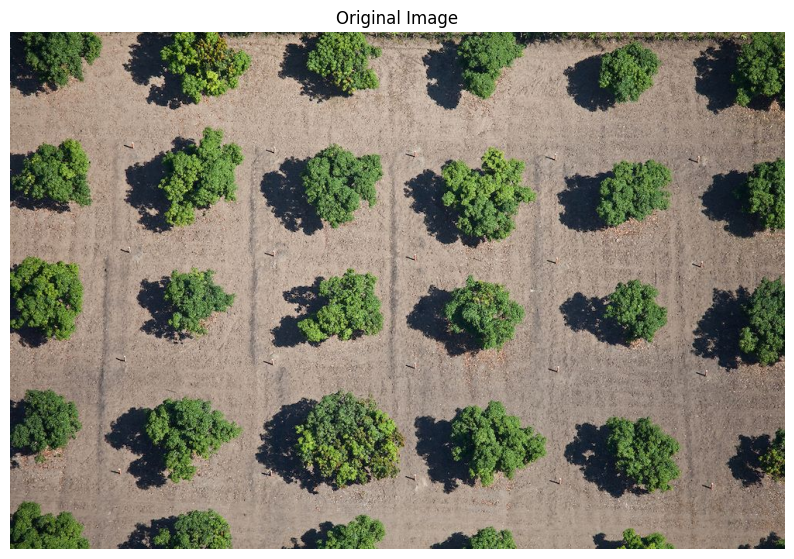

In [2]:
from plant_search.load_image import load_image, plot_image

# file_path = '../input/ESPG-4326-orthophoto.tif'
# file_path = '../input/MADRID_RGB.tif'
file_path = '../input/aerial-trees.jpg'

original_image  = load_image(file_path)
if original_image  is not None:
    plot_image(original_image , "Original Image")

Binary mask loaded with shape: (667, 1000)
Unique values in mask: [False  True]


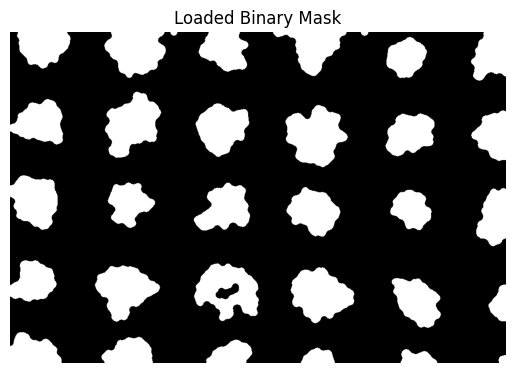

In [3]:
from skimage.io import imread
import matplotlib.pyplot as plt

# Load binary mask from PNG
mask_path = '../outputs/binary_mask.png'

binary_mask = imread(mask_path) > 0  # Convert back to binary (True/False)

# Verify the shape and values
print(f"Binary mask loaded with shape: {binary_mask.shape}")
print(f"Unique values in mask: {np.unique(binary_mask)}")

# Visualize the binary mask
plt.imshow(binary_mask, cmap="gray")
plt.title("Loaded Binary Mask")
plt.axis("off")
plt.show()


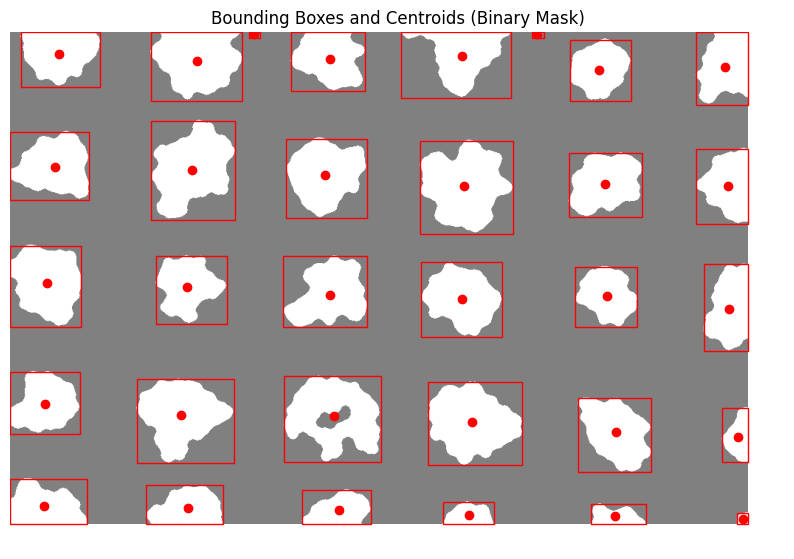

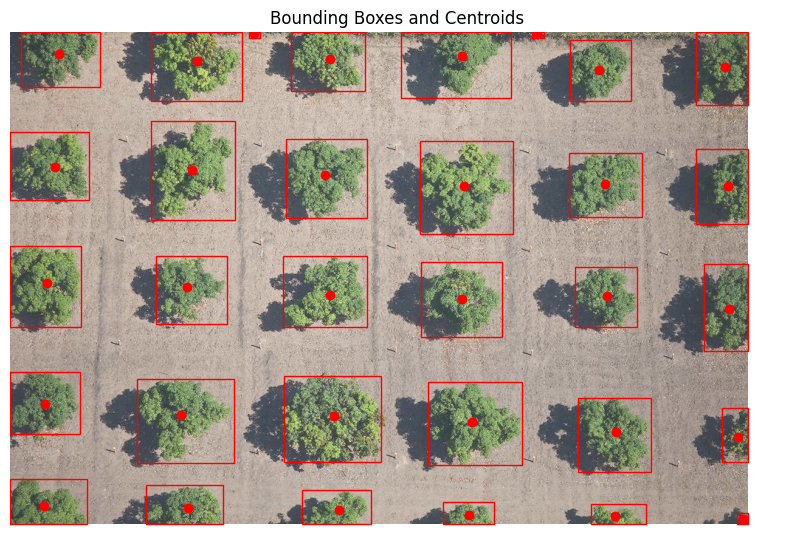

Number of regions (detected plants): 32
Number of centroids (detected plants): 32


In [4]:

from skimage.measure import label, regionprops
from skimage.morphology import closing, disk

# Step 1: Preprocess the binary mask
selem = disk(3)  # Structuring element
cleaned_mask = closing(binary_mask, selem)  # Fill small gaps

# Step 2: Label connected components
labeled_mask = label(cleaned_mask)
regions = regionprops(labeled_mask)

# Step 3: Extract centroids and bounding boxes
centroids = []
bounding_boxes = []

for region in regions:
    # Centroid
    centroid = region.centroid  # (row, col)
    centroids.append((round(centroid[1], 2), round(centroid[0], 2)))  # Format x, y to 2 decimal places

    # Bounding box
    min_row, min_col, max_row, max_col = region.bbox
    bounding_boxes.append(((min_col, min_row), (max_col, max_row)))





# Step 4: Visualize results on binary mask
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cleaned_mask, cmap="gray", alpha=0.5)
for bbox, centroid in zip(bounding_boxes, centroids):
    (min_col, min_row), (max_col, max_row) = bbox # Draw bounding box
    ax.add_patch(plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                                edgecolor="red", fill=False, linewidth=1))
    ax.plot(centroid[0], centroid[1], "ro")  # Plot centroid
ax.set_title("Bounding Boxes and Centroids (Binary Mask)")
ax.axis("off")

# Step 5: Visualize results on original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(original_image, alpha=0.8)
for bbox, centroid in zip(bounding_boxes, centroids):
    (min_col, min_row), (max_col, max_row) = bbox # Draw bounding box
    ax.add_patch(plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                                edgecolor="red", fill=False, linewidth=1))
    ax.plot(centroid[0], centroid[1], "ro")  # Plot centroid

# Step 4: Visualize the result
ax.set_title("Bounding Boxes and Centroids")
ax.axis("off")
plt.show()


print(f"Number of regions (detected plants): {len(regions)}")
print(f"Number of centroids (detected plants): {len(centroids)}")

# Output centroids
# print("Detected Centroids:")
# for idx, centroid in enumerate(centroids):
#     print(f"Plant {idx + 1}: Centroid at (x={centroid[0]:.2f}, y={centroid[1]:.2f})")


## Post-Processing

### Size and Shape Analysis

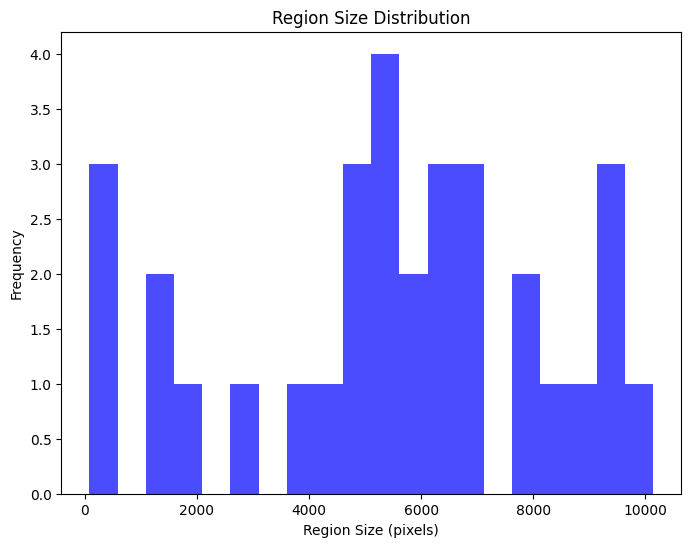

In [5]:
# Analyze size and shape
region_sizes = [region.area for region in regions]
aspect_ratios = [(region.bbox[3] - region.bbox[1]) / (region.bbox[2] - region.bbox[0]) for region in regions]

# Plot histogram of region sizes
plt.figure(figsize=(8, 6))
plt.hist(region_sizes, bins=20, color="blue", alpha=0.7)
plt.title("Region Size Distribution")
plt.xlabel("Region Size (pixels)")
plt.ylabel("Frequency")
plt.show()


### Filtering Regions

Filtering our target regions by total size.
- Size Filtering: Discard regions smaller or larger than certain thresholds.
- Aspect Ratio Filtering: Filter regions based on the shape (e.g., avoid very elongated or irregular shapes).
- Circularity/Compactness: Use the compactness or circularity of regions to identify potential plants.

In [6]:
filtered_regions = []
min_size = 100  # Minimum number of pixels
max_size = 1000  # Maximum number of pixels

for region in regions:
    if min_size <= region.area <= max_size:
        filtered_regions.append(region)

print(f"Number of regions after filtering: {len(filtered_regions)}")


Number of regions after filtering: 1


In [ ]:
from skimage.measure import label, regionprops
from skimage.morphology import closing, disk
from matplotlib.patches import Rectangle
from skimage.morphology import remove_small_objects, remove_small_holes

# Example binary mask (replace this with your loaded mask)
# binary_mask = np.random.choice([0, 1], size=(512, 512), p=[0.98, 0.02])  # Example mask
# original_image = np.random.random((512, 512, 3))  # Replace with your original RGB image

# Preprocess binary mask
selem = disk(3)  # Structuring element
cleaned_mask = closing(binary_mask, selem)  # Fill small gaps


# Remove small objects and holes
cleaned_mask = remove_small_objects(cleaned_mask, min_size=50)
cleaned_mask = remove_small_holes(cleaned_mask, area_threshold=50)

labeled_mask = label(cleaned_mask)
regions = regionprops(labeled_mask)
largest_region = max(r.area for r in regions)

# Interactive visualization function
def filter_regions(min_size, max_size):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(original_image, alpha=0.8)

    for region in regions:
        min_row, min_col, max_row, max_col = region.bbox
        centroid = region.centroid

        # Filter regions based on size
        if (min_size >= region.area) or (region.area > max_size):
            # Valid regions (green bounding box)
            ax.add_patch(Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                                   edgecolor="red", fill=False, linewidth=2))
            ax.plot(centroid[1], centroid[0], "ro")  # Green centroid
        else:
            # Filtered-out regions (red bounding box)
            ax.add_patch(Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                                   edgecolor="green", fill=False, linewidth=2))
            ax.plot(centroid[1], centroid[0], "go")  # Red centroid

    ax.set_title(f"Region Filtering: min_size={min_size}, max_size={max_size}")
    ax.axis("off")
    plt.show()



print(largest_region)

# Create interactive sliders for size thresholds
interact(filter_regions,
         min_size=IntSlider(value=100, min=0, max=largest_region, step=10, description="Min Size"),
         max_size=IntSlider(value=(largest_region//2), min=100, max=largest_region, step=10, description="Max Size"));



10138.0


interactive(children=(IntSlider(value=100, description='Min Size', max=10138, step=10), IntSlider(value=5069, …

## Exporting Results

In [8]:
import pandas as pd

# Create a DataFrame with bounding box and centroid data
results = pd.DataFrame({
    "Min Row": [region.bbox[0] for region in regions],
    "Min Col": [region.bbox[1] for region in regions],
    "Max Row": [region.bbox[2] for region in regions],
    "Max Col": [region.bbox[3] for region in regions],
    "Centroid X": [round(region.centroid[1], 2) for region in regions],
    "Centroid Y": [round(region.centroid[0], 2) for region in regions],
    "Area": [region.area for region in regions]
})

# Save to CSV
results.to_csv("../outputs/plant_detection_results.csv", index=False)
print("Results saved to '../outputs/plant_detection_results.csv'.")


Results saved to '../outputs/plant_detection_results.csv'.


## TODO

- Current Limitations:
    - Reliance on binary masks; inaccuracies in the mask affect results.
    - Simple bounding box approximation; does not account for irregular shapes.
- Potential Improvements:
    - Integrate a trained model for more robust segmentation and detection.
    - Add multi-class detection if plants need to be categorized.